In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import re

import networkx.algorithms.community as comms

In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

In [3]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [4]:
lasts = []
for n in name:
    lasts.append((re.findall('[A-Z][^A-Z]*', n))[0])

In [5]:
#Read in graph and find and isolate the greatest connected component

B = nx.read_edgelist(data)
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, name=name[j], last=lasts[j], sex=sex[j]) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i]) # why role is in a list?
    i+=1

p_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
c_nodes = set(G) - p_nodes # crimes

# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])

P 754 2127


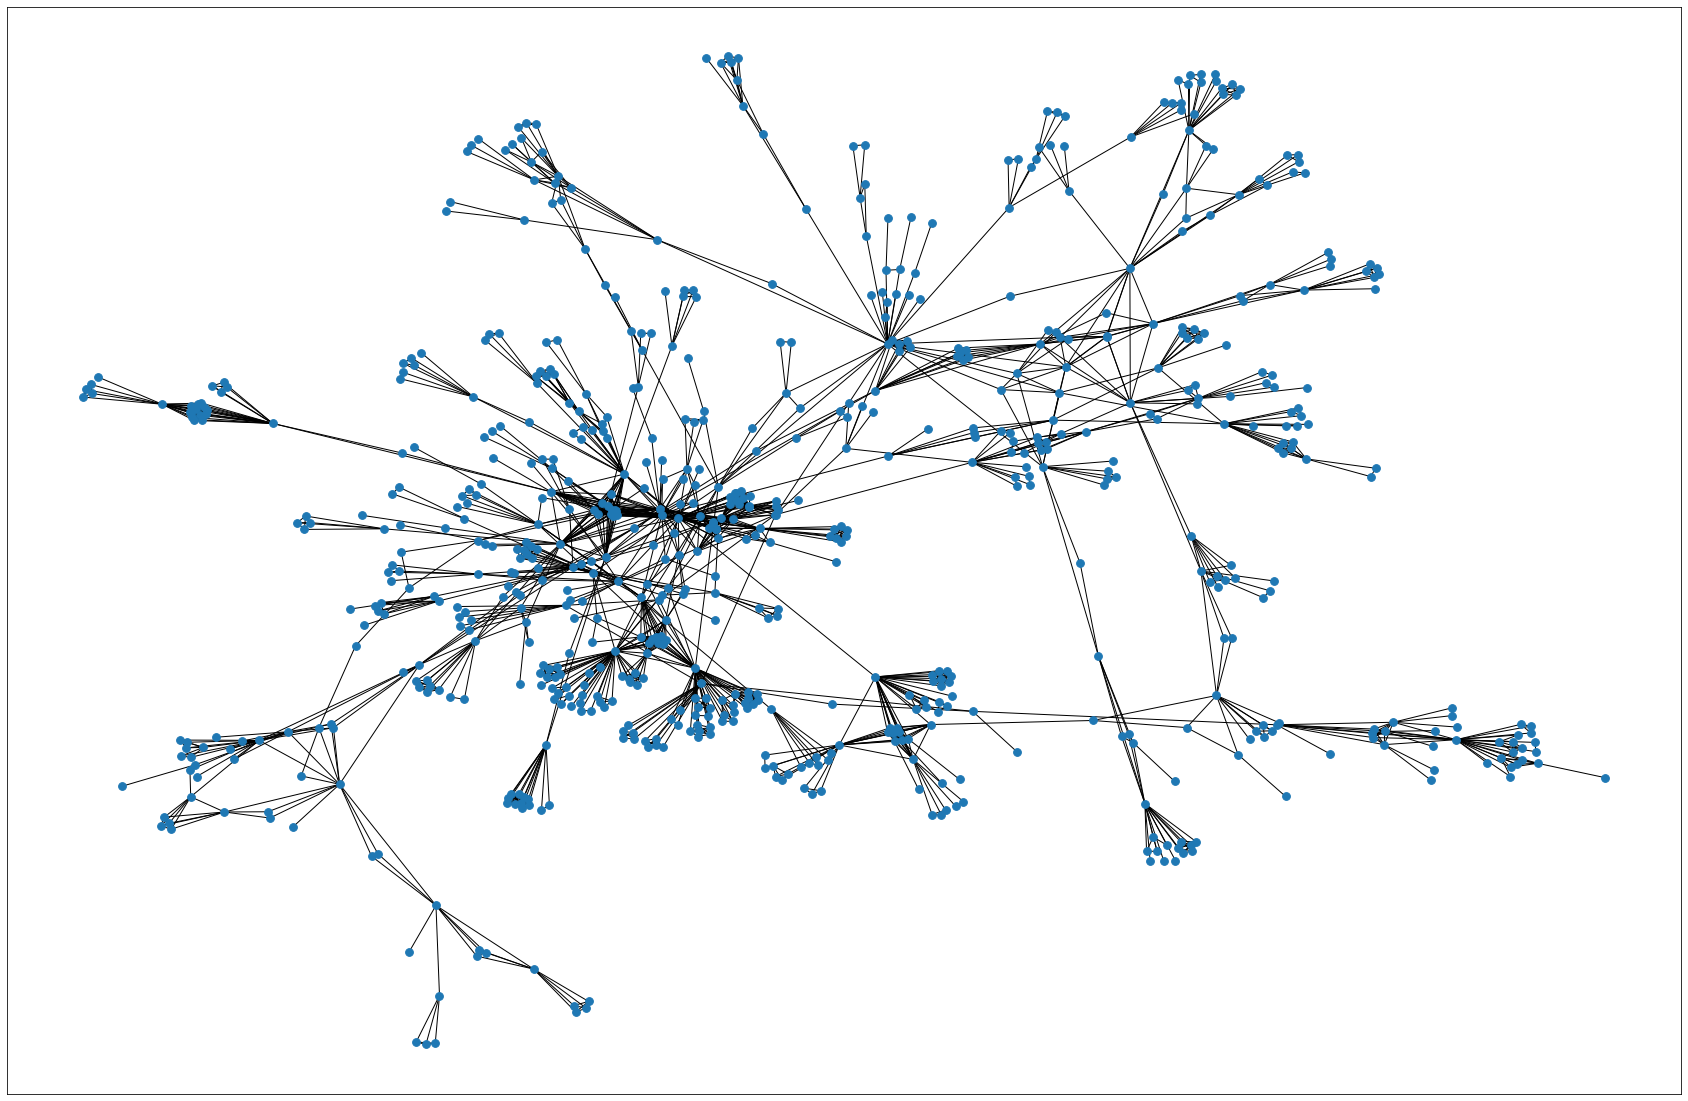

In [6]:
#Seperate the nodes for People and Crimes
p_nodes_gcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_gcc = set(G0) - p_nodes_gcc

#print(len(p_nodes_gcc), len(c_nodes_gcc))

# project onto people and visualise
P = bipartite.weighted_projected_graph(G0, p_nodes_gcc)

print('P',len(P.nodes()), len(P.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, with_labels=False)

In [7]:
POI = 'p815' #set a Person of Interest

communities = sorted(comms.greedy_modularity_communities(P), key=len, reverse=True) #30 coms modularity 0.845
#communities = sorted(comms.label_propagation_communities(P), key=len, reverse=True) #89 coms modularity 0.787

# Count the communities
print(f"There are {len(communities)} communities.")

comms.modularity(P, communities)

for i in range(len(communities)):
    if POI in communities[i]:
        print(i)
        highlight = i

There are 30 communities.
2


0 122
1 84
2 63
3 55
4 55
5 45
6 34
7 30
8 30
9 28


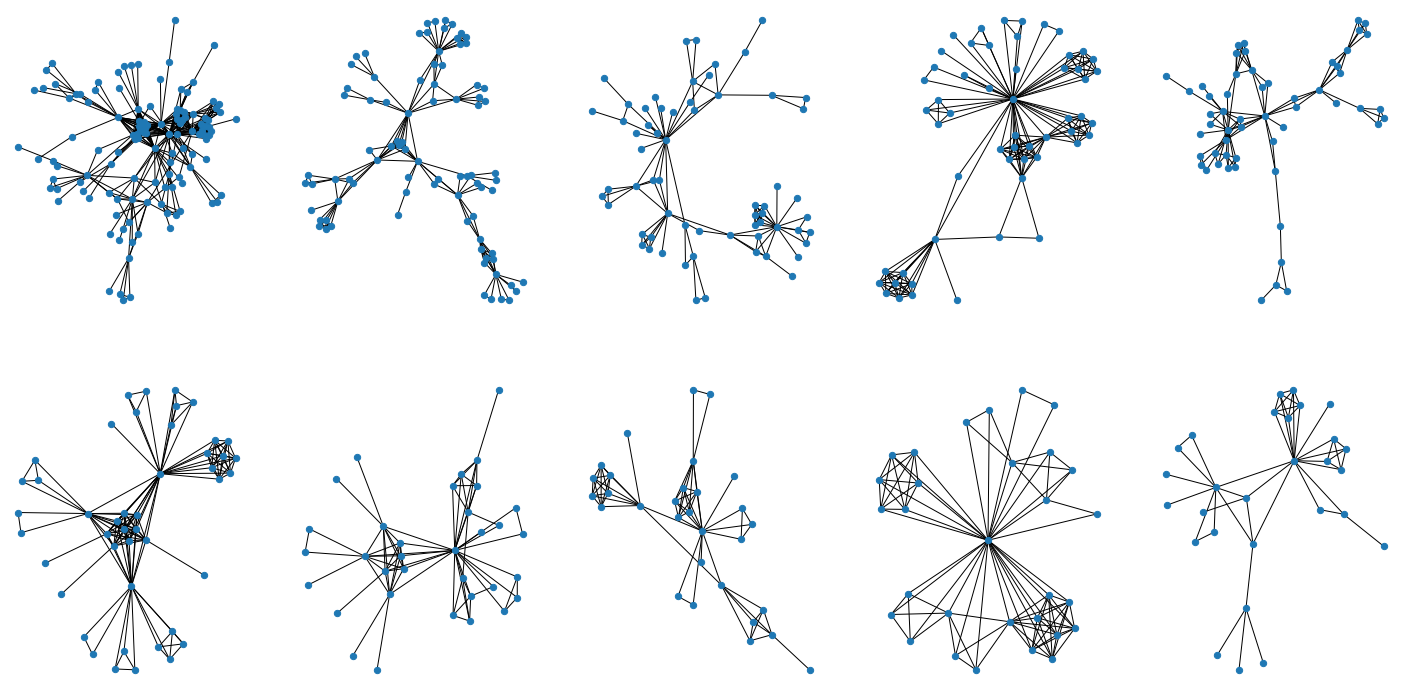

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    com = P.subgraph(communities[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
plt.savefig(f'../Figures/1-10_community.jpg')

10 26
11 25
12 24
13 14
14 14
15 14
16 13
17 9
18 8
19 8


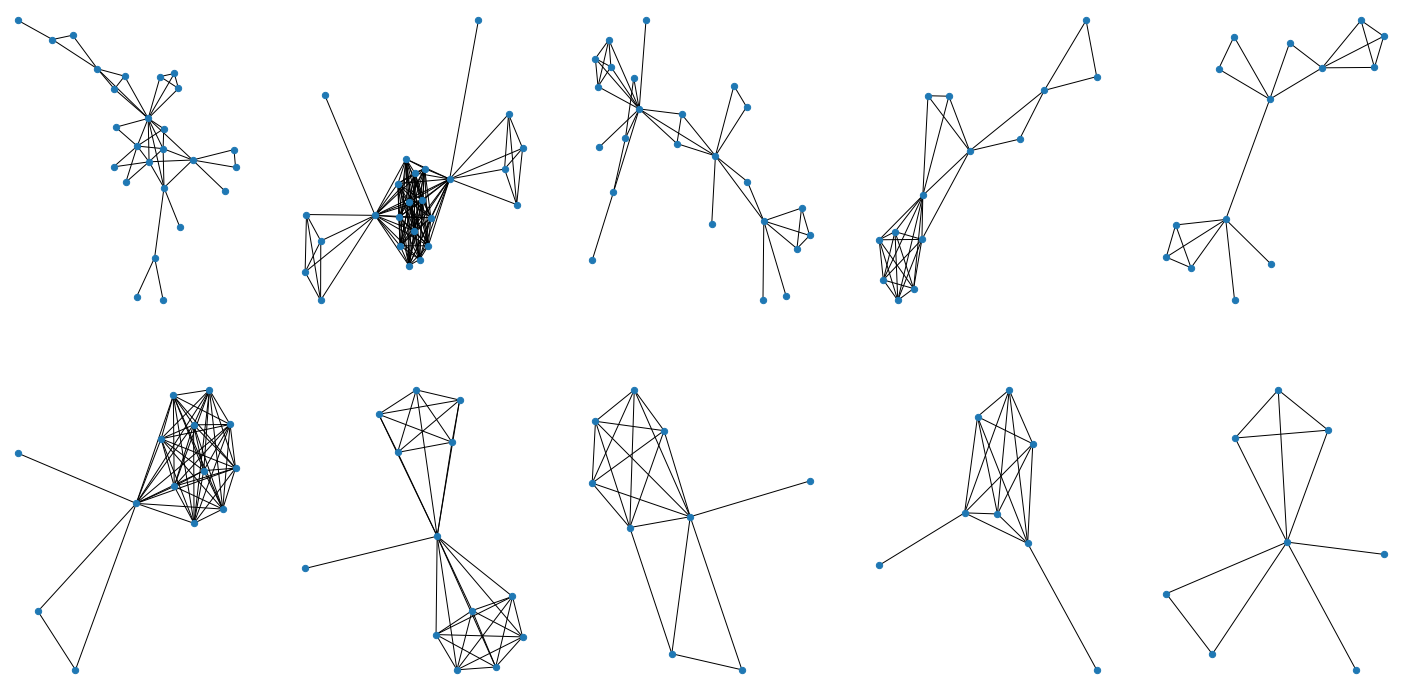

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(10,20): 
    com = P.subgraph(communities[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-9)
    nx.draw_spring(com, node_size=40)
plt.savefig(f'../Figures/11-20_community.jpg')

20 7
21 7
22 7
23 6
24 6
25 5
26 4
27 4
28 4
29 3


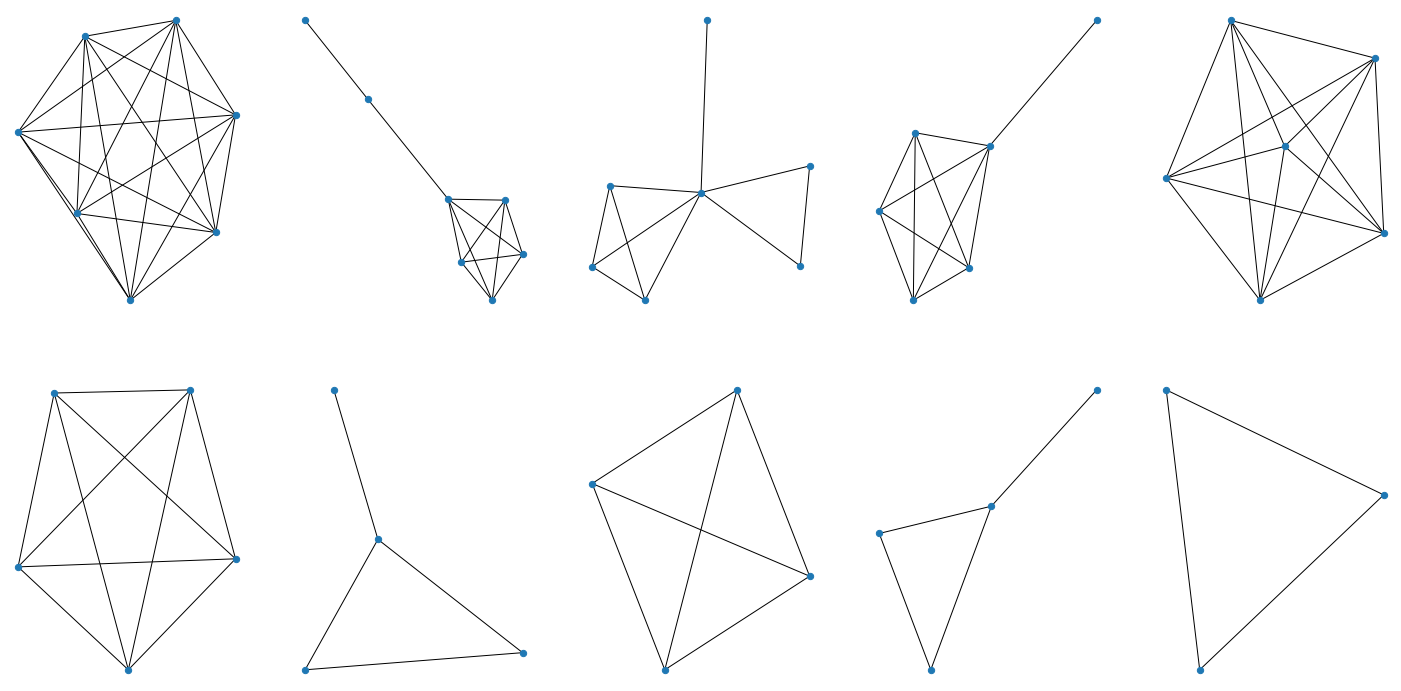

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(20,30): 
    com = P.subgraph(communities[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-19)
    nx.draw_spring(com, node_size=40)
plt.savefig(f'../Figures/21-30_community.jpg')

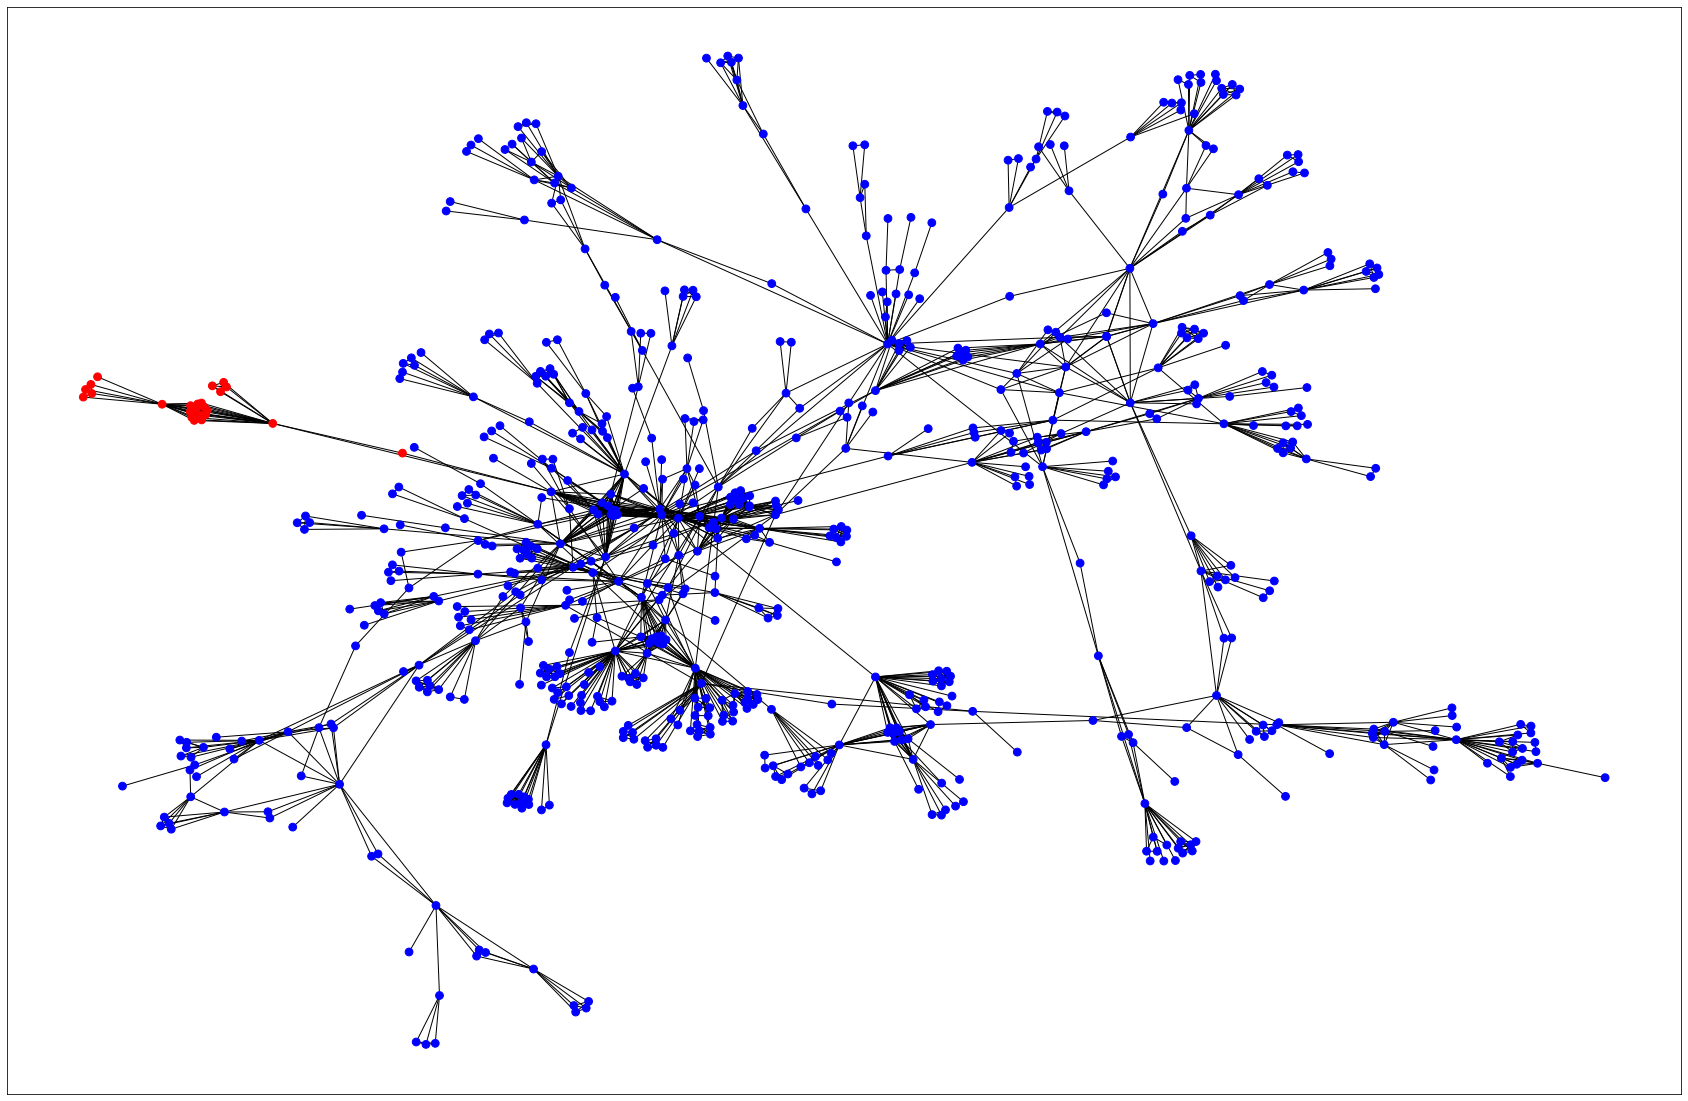

In [11]:
highlight = 11 #choose a community to highlight via it's index in the communities list

node_col = []

for node in P.nodes():
    if node in communities[highlight]:
        node_col.append('red')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_people_projection.jpg')

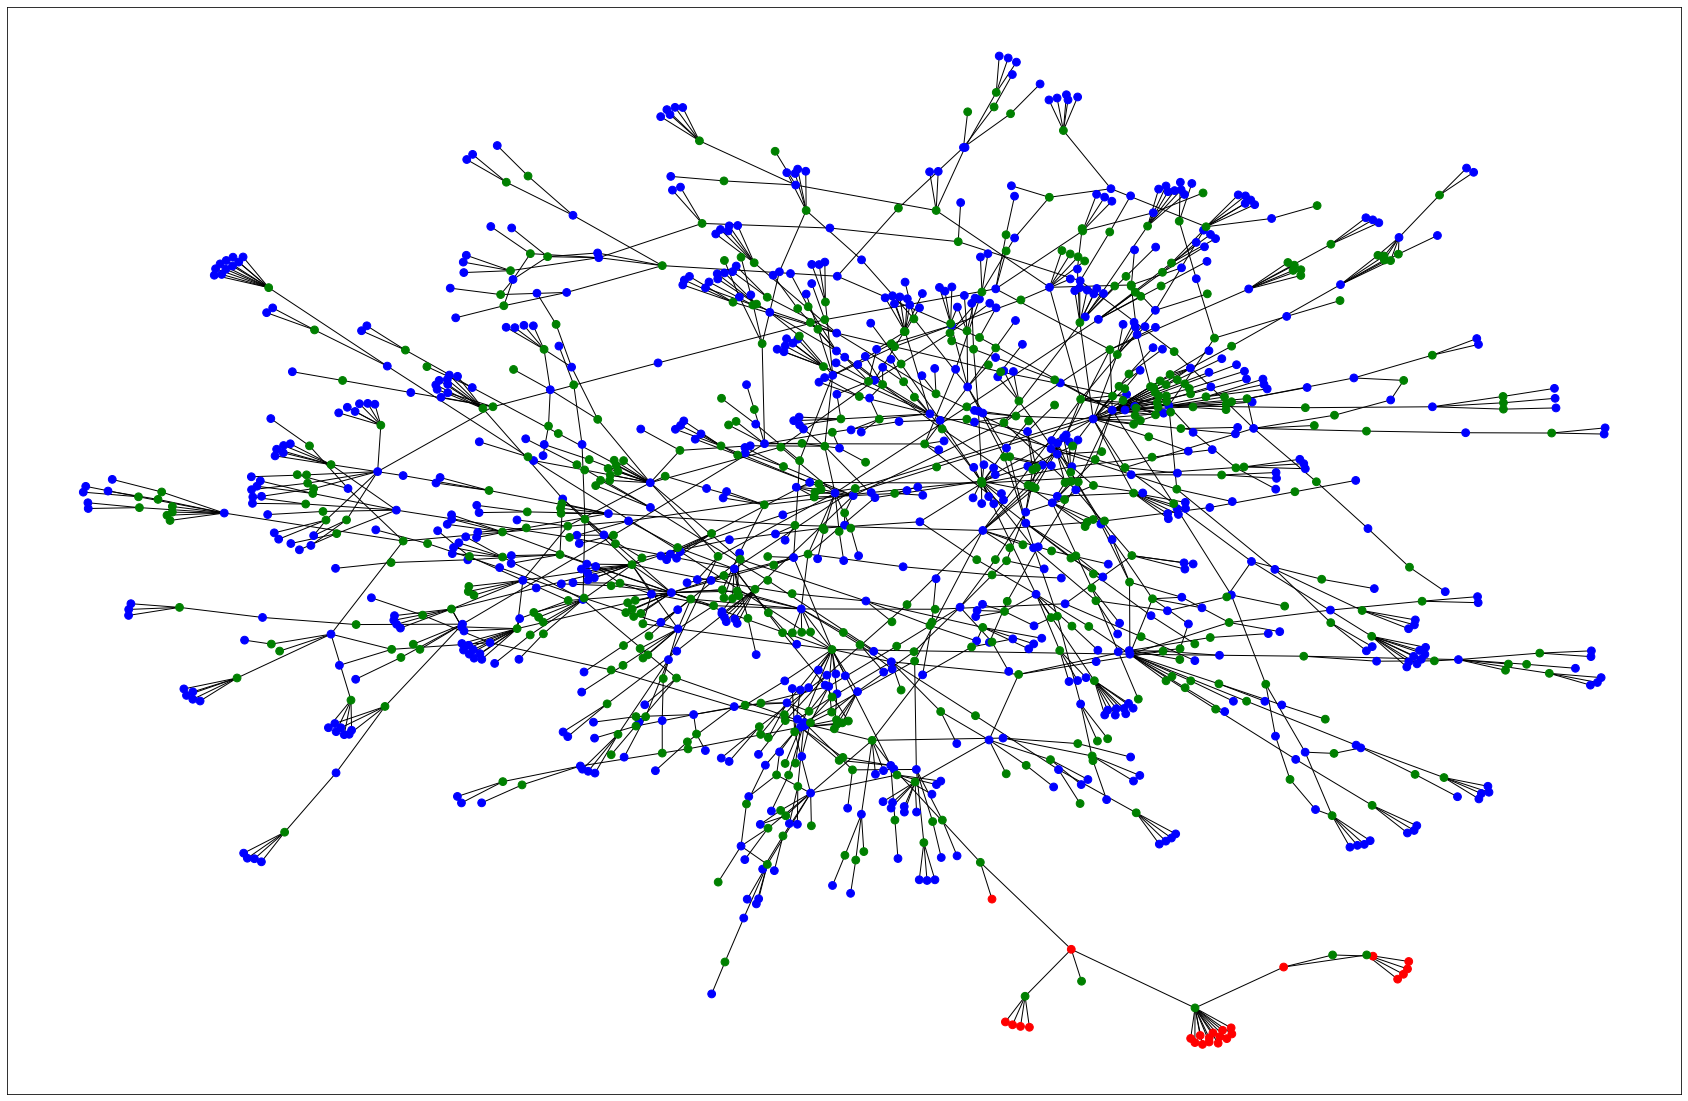

In [12]:
node_col = []

for node in G0.nodes():
    if node in communities[highlight]:
        node_col.append('red')
    elif node in c_nodes_gcc:
        node_col.append('green')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_lcc_no projection.jpg')

In [13]:
ed = []
lab = {}

for per in communities[highlight]:
    print('\n------\n\n',nx.get_node_attributes(G, 'last')[per], nx.get_node_attributes(G, 'sex')[per])
    lab[per] = (nx.get_node_attributes(G, 'last')[per], per)
    for c in G.edges([per]):
        print(c, nx.get_edge_attributes(G0, 'role')[c])
        ed.append(c[1])
        lab[c[1]] = f'{c[1]}'


------

 Gunnerson 0
('p397', '153') Victim
('p397', '188') Suspect
('p397', '332') Victim
('p397', '403') Witness

------

 Kennard 1
('p487', '153') Victim

------

 Carlson 1
('p219', '153') Suspect
('p219', '270') Victim
('p219', '271') Suspect

------

 Jordan 1
('p473', '153') Witness

------

 Carlson 1
('p218', '270') Suspect

------

 Bendix 1
('p149', '153') Suspect

------

 Daly 1
('p280', '332') Witness

------

 Smothers 1
('p726', '153') Witness

------

 Powers 0
('p654', '332') Suspect

------

 York 1
('p98', '153') Witness

------

 Harrigan 1
('p408', '153') Suspect

------

 Swift 1
('p757', '332') Witness

------

 Mc 0
('p562', '153') Suspect

------

 Saxe 0
('p698', '153') Witness

------

 Conklin 0
('p254', '271') Suspect

------

 Powers 1
('p653', '271') Suspect

------

 Williams 1
('p829', '271') Suspect

------

 Fagen 0
('p322', '332') Victim

------

 Stone 1
('p751', '271') Suspect

------

 Kelly 0
('p484', '153') Victim

------

 Armstrong 0
('p123

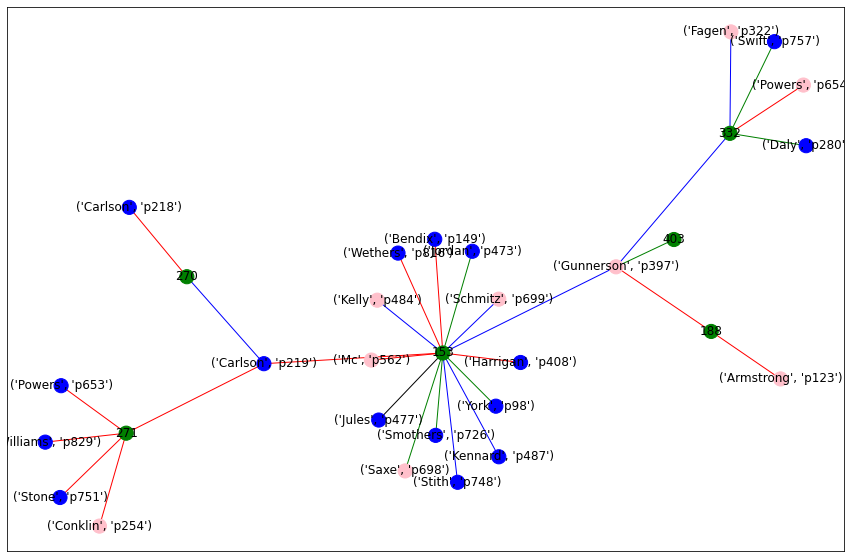

In [14]:
for i in communities[highlight]:
    ed.append(i)

nc = []
ec = []

hi = G0.subgraph(ed)

for node in hi:
    if node in communities[highlight]:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('blue')
        else:
            nc.append('pink')
    elif node in c_nodes_gcc:
        nc.append('green')
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
for edge in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[edge]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')
        
        

plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

plt.savefig(f'../Figures/community_{highlight}_focus_labelled.jpg')

## Now same again, but using crimes as projection.

C 509 2284


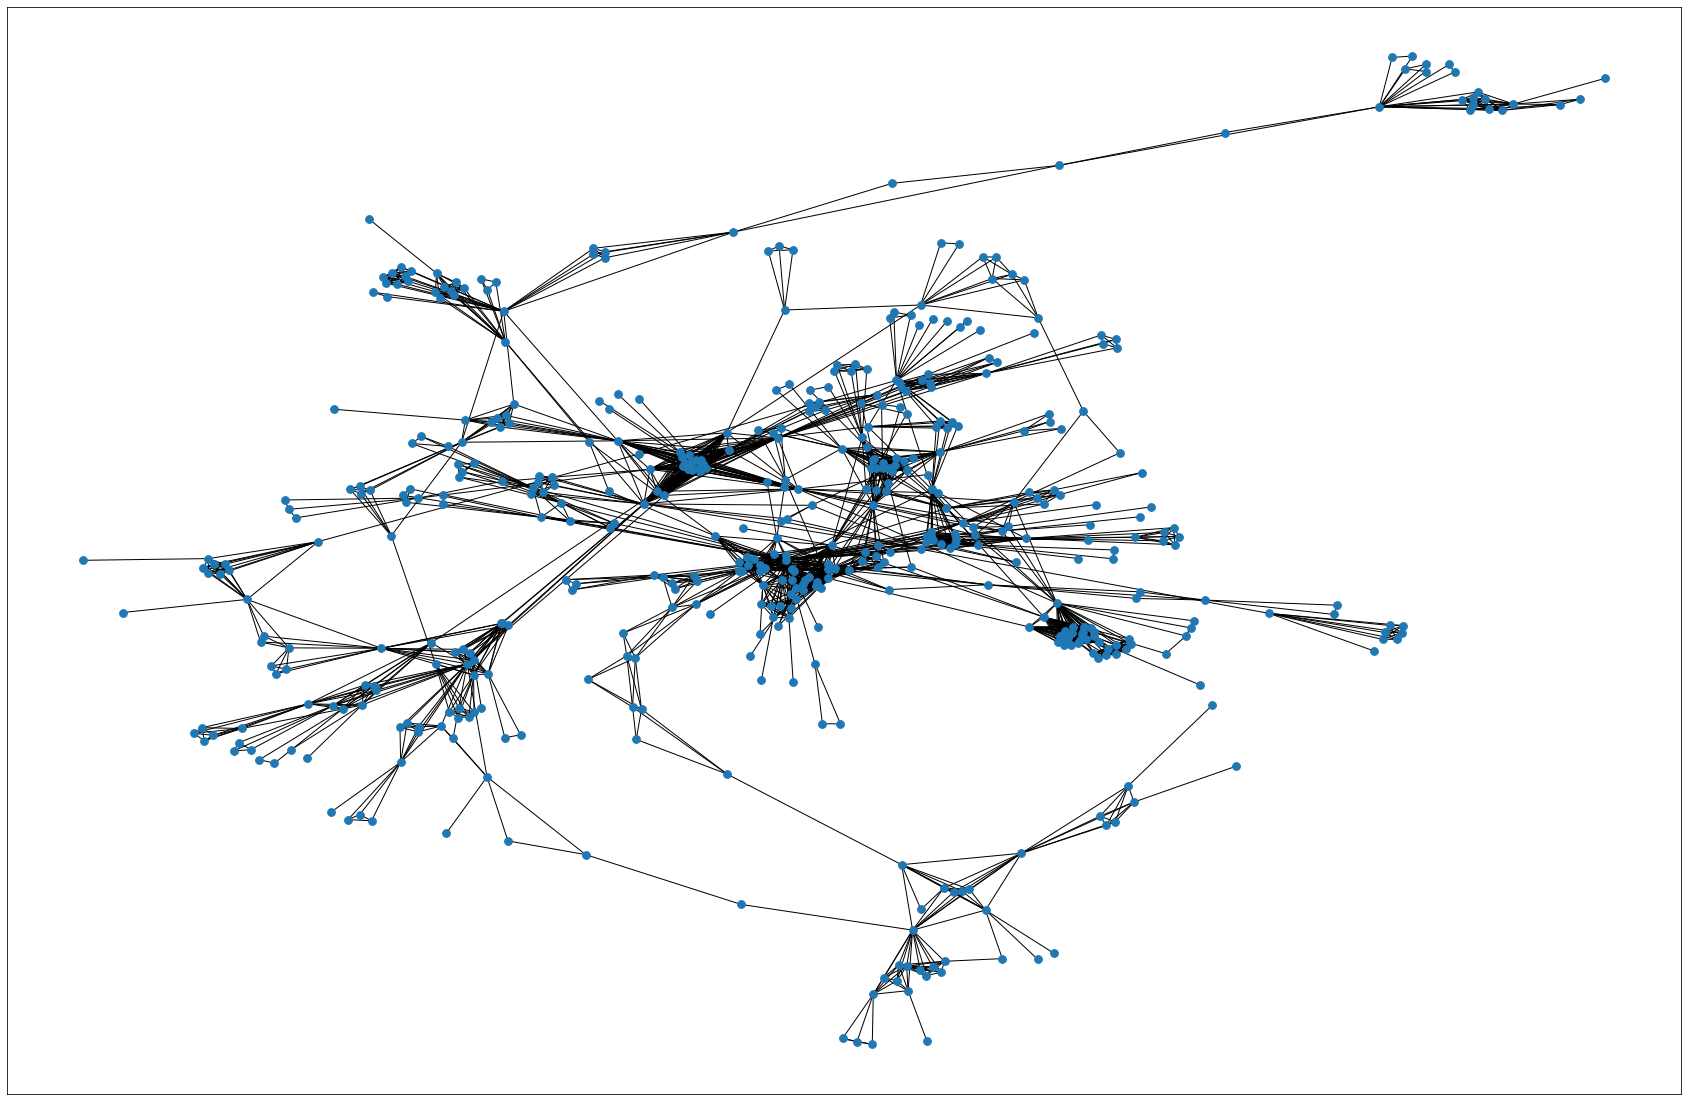

In [15]:
# project onto crimes and visualise
C = bipartite.weighted_projected_graph(G0, c_nodes_gcc)

print('C',len(C.nodes()), len(C.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(C, seed=23)

nx.draw_networkx(C, pos, node_size=60, with_labels=False)

In [16]:
communities_c = sorted(comms.greedy_modularity_communities(C), key=len, reverse=True) #14 coms modularity 0.813
#communities_c = sorted(comms.label_propagation_communities(C), key=len, reverse=True) #50 coms modularity 0.763

# Count the communities
print(f"There are {len(communities_c)} communities.")

comms.modularity(C, communities_c)

There are 14 communities.


0.8133931270647268

0 76
1 56
2 48
3 43
4 43
5 42
6 39
7 37
8 36
9 34


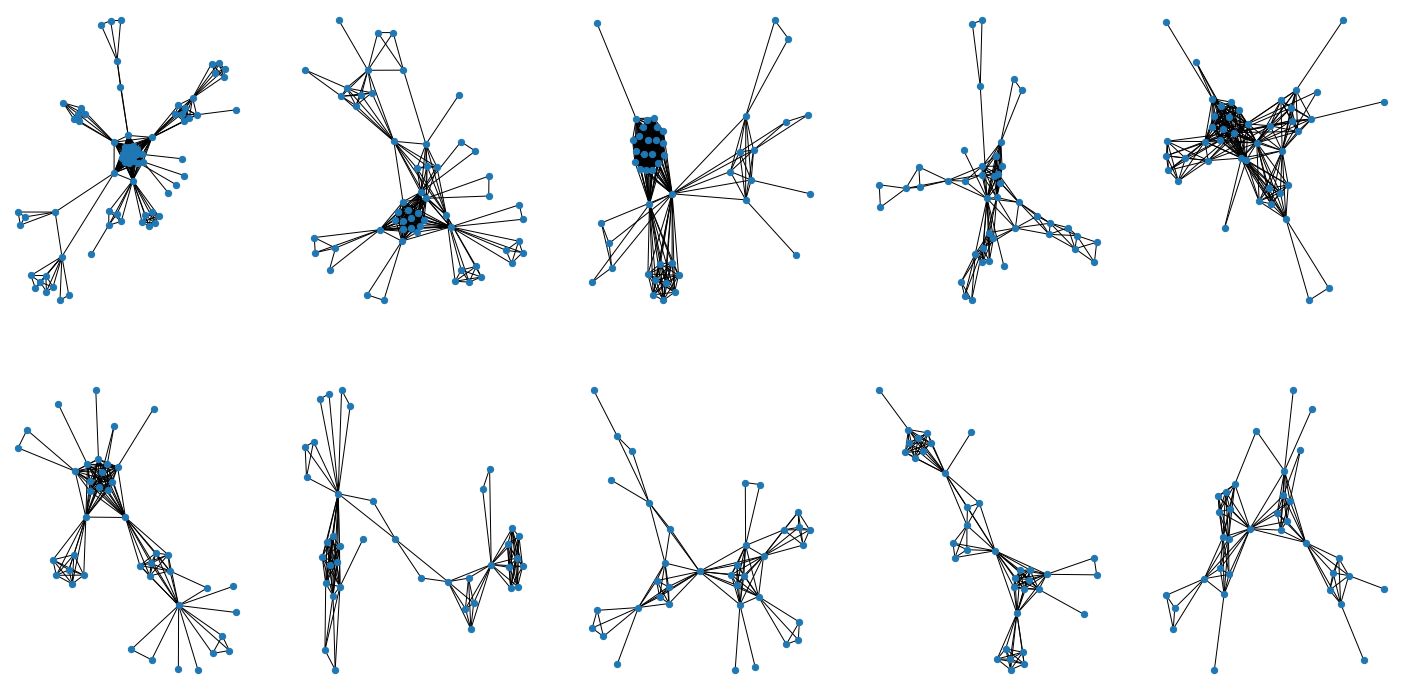

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    com = C.subgraph(communities_c[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/1-10_C_community.jpg')

10 18
11 16
12 13
13 8


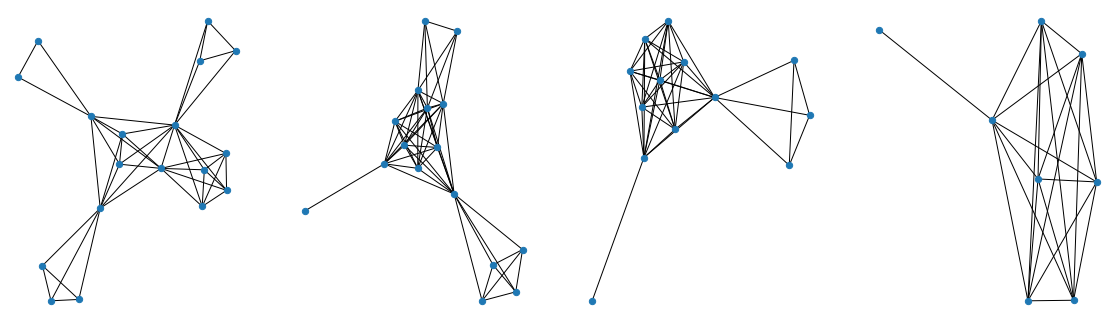

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(10,14): 
    com = C.subgraph(communities_c[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-9)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/11-14_C_community.jpg')

0


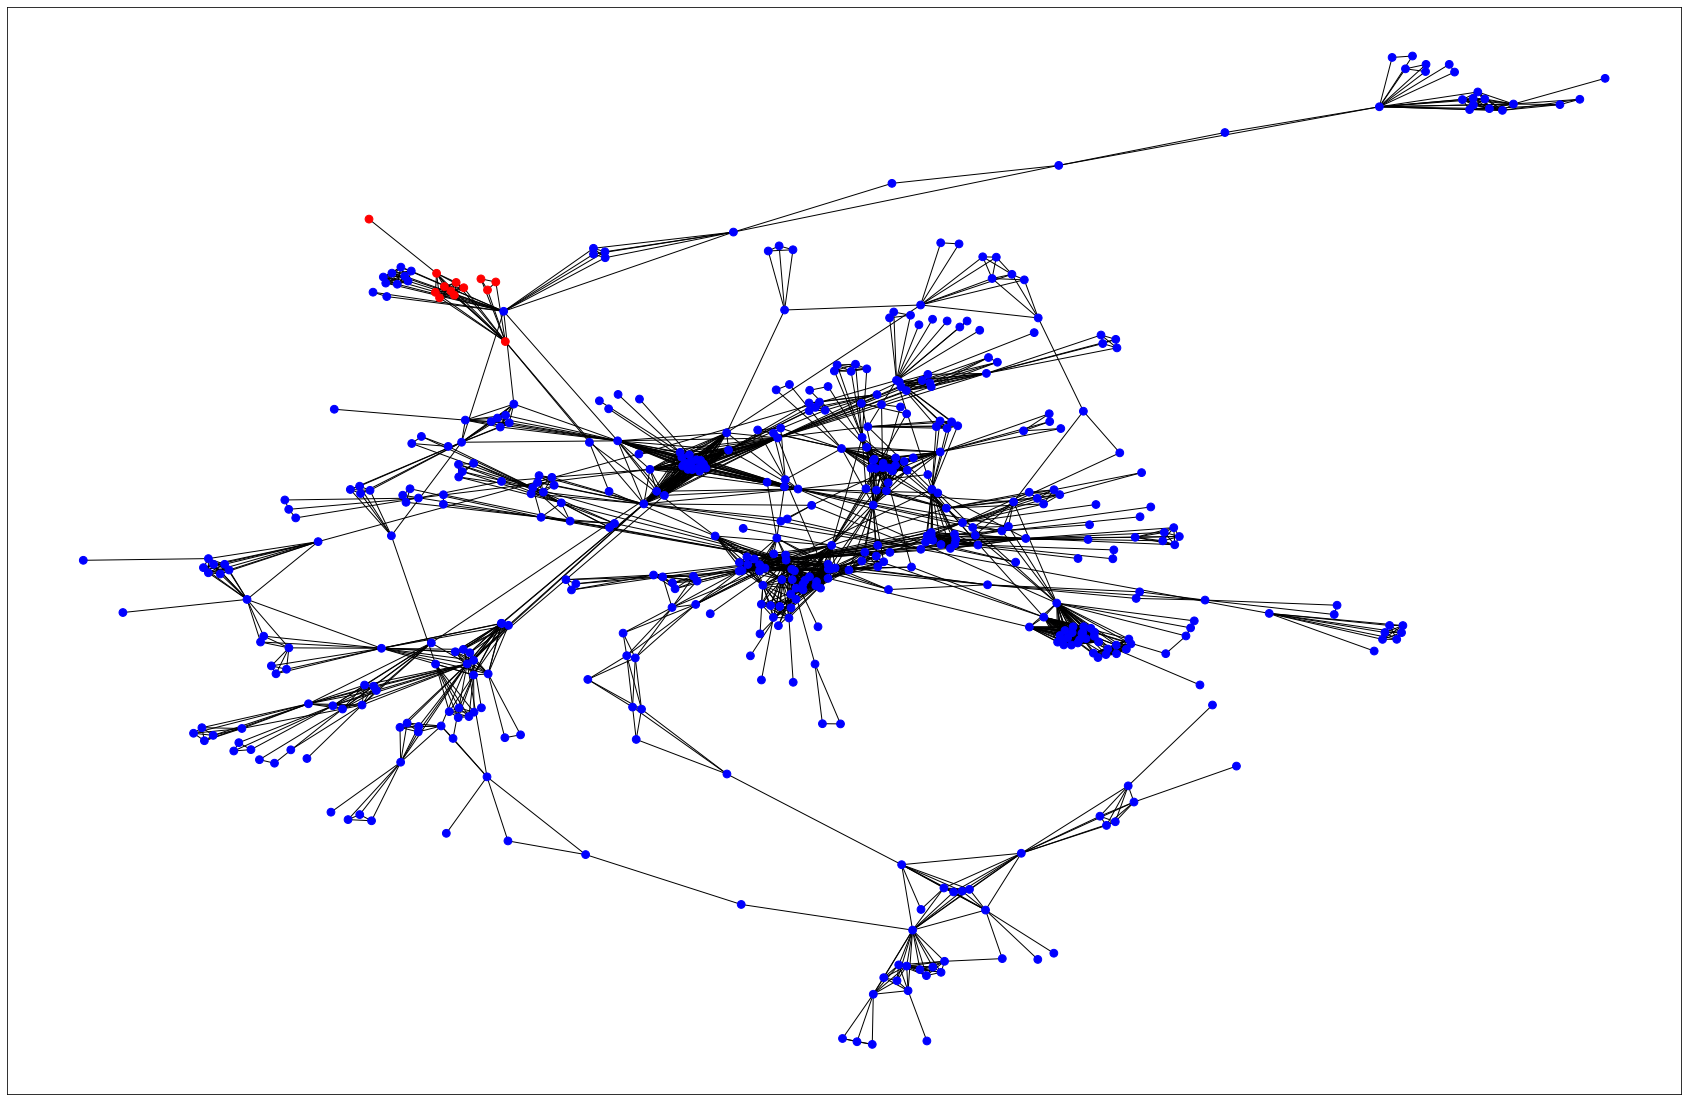

In [19]:
COI = '415'
for i in range(len(communities_c)):
    if COI in communities_c[i]:
        print(i)
        highlight = i

highlight = 12 #choose a community to highlight via it's index in the communities list

node_col = []

for node in C.nodes():
    if node in communities_c[highlight]:
        node_col.append('red')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(C, seed=23)

nx.draw_networkx(C, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_crime_projection.jpg')

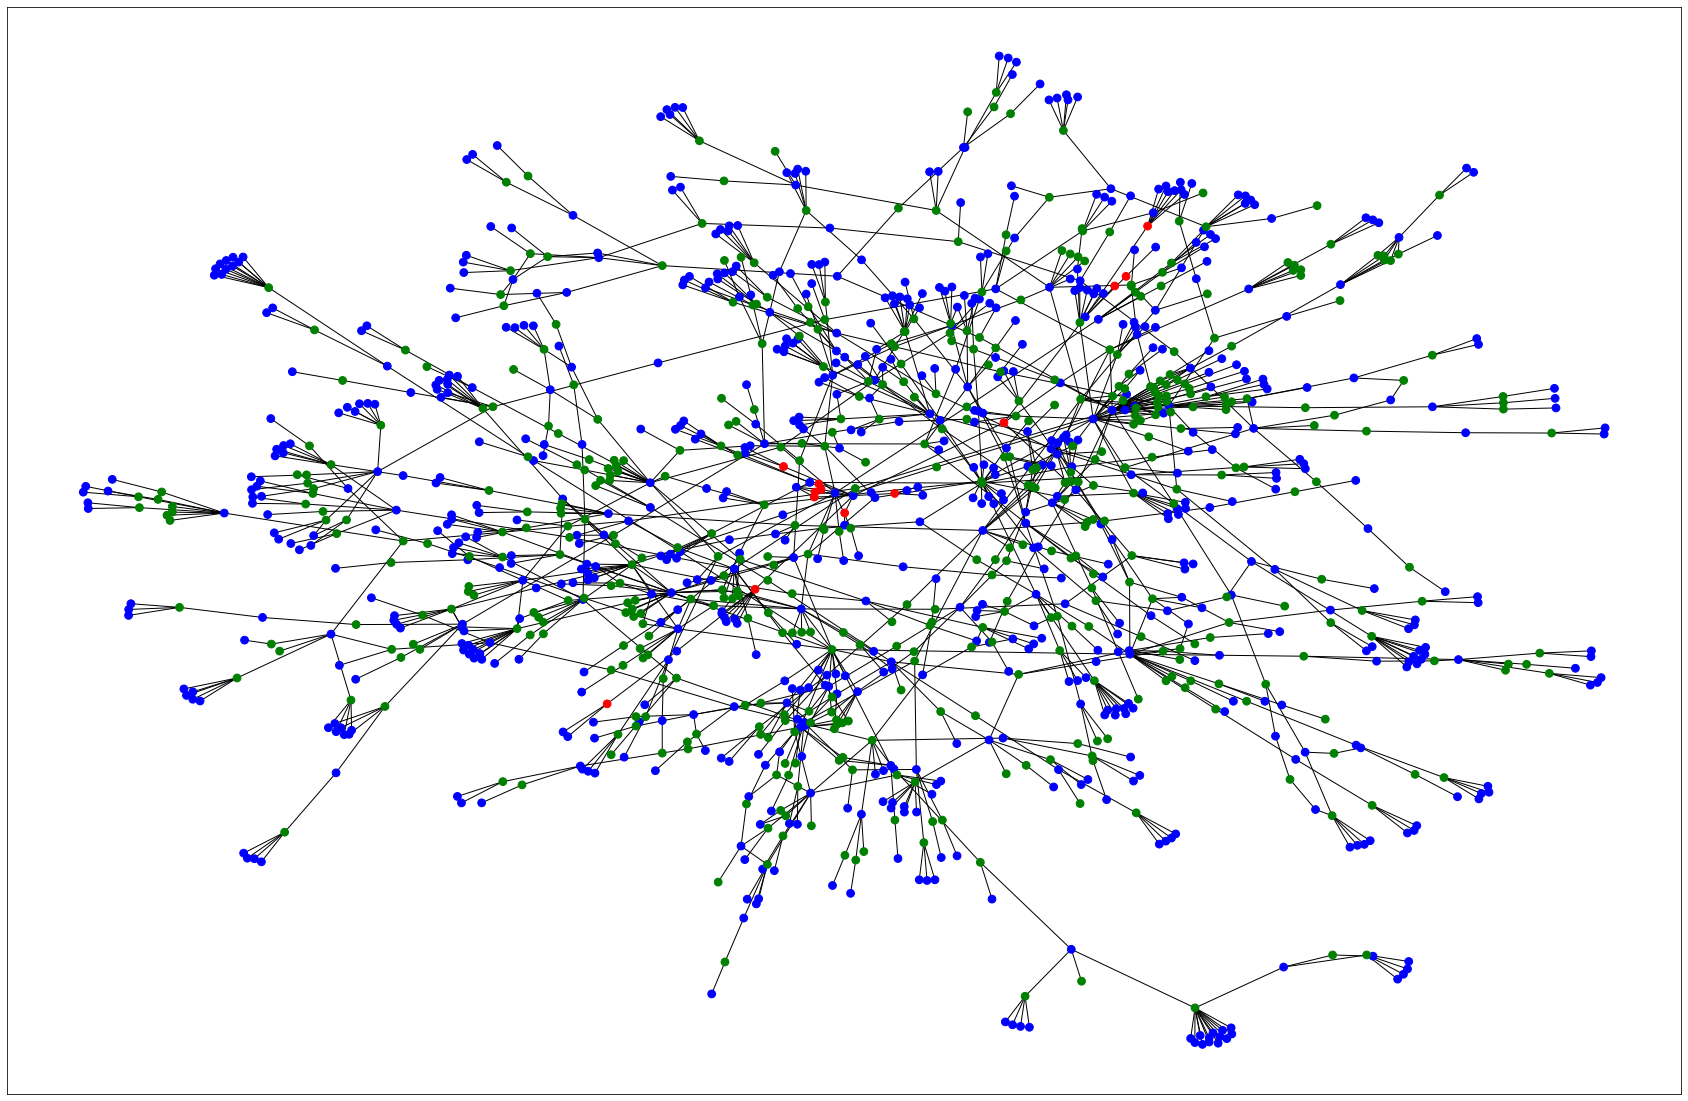

In [20]:
node_col = []

for node in G0.nodes():
    if node in communities_c[highlight]:
        node_col.append('red')
    elif node in p_nodes_gcc:
        node_col.append('blue')
    else:
        node_col.append('green')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/c_community_{highlight}_lcc_no projection.jpg')

In [21]:
lab = {}
no = []
ec = []
nc = []

for cri in communities_c[highlight]:
    no.append(cri)
    lab[cri] = f'{cri}'
    for edge in G0.edges(cri):
        no.append(edge[1])
    
no = set(no)       
for node in no:
    if node in c_nodes_gcc:
        nc.append('green')
        
    elif nx.get_node_attributes(G, 'sex')[node] == '1':
        nc.append('blue')
        lab[node] = (nx.get_node_attributes(G, 'last')[node], node)
    else:
        nc.append('pink')
        lab[node] = (nx.get_node_attributes(G, 'last')[node], node)

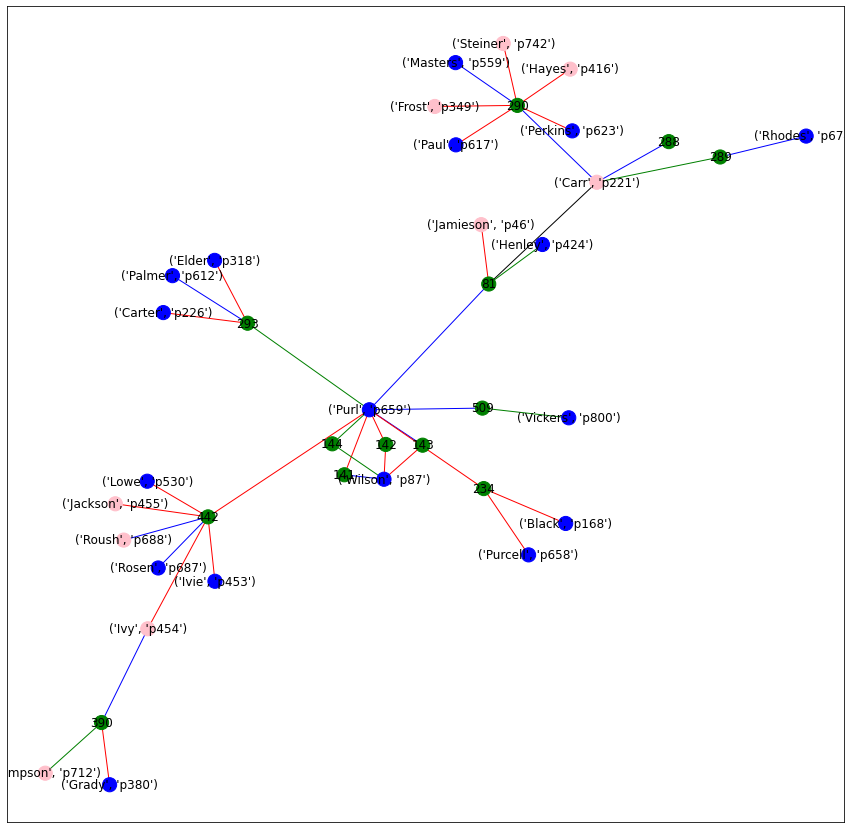

In [22]:
hi = G0.subgraph(no)
ec = []

for c in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[c]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')

plt.rcParams.update({'figure.figsize': (15, 15)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, edge_color=ec, node_color = nc, labels=lab)

plt.savefig(f'../Figures/c_community_{highlight}_focus_labelled.jpg')

## Look at suspects only:

In [23]:
sus_edge = []
sus_nodes = []
for edge in G0.edges():
    if nx.get_edge_attributes(G, 'role')[edge] == 'Suspect':
        sus_edge.append(edge)
        sus_nodes.append(edge[0])

for i in c_nodes_gcc:
    sus_nodes.append(i)
        


len(set(sus_nodes)),len(sus_edge)

(938, 641)

In [24]:
S = G.subgraph(sus_nodes)

Scc = sorted(nx.connected_components(S), key=len, reverse=True)
# selecting the biggest component
S0 = S.subgraph(Scc[0])

p_nodes_scc = {n for n, d in S0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_scc = set(S0) - p_nodes_scc

Sp 381 873


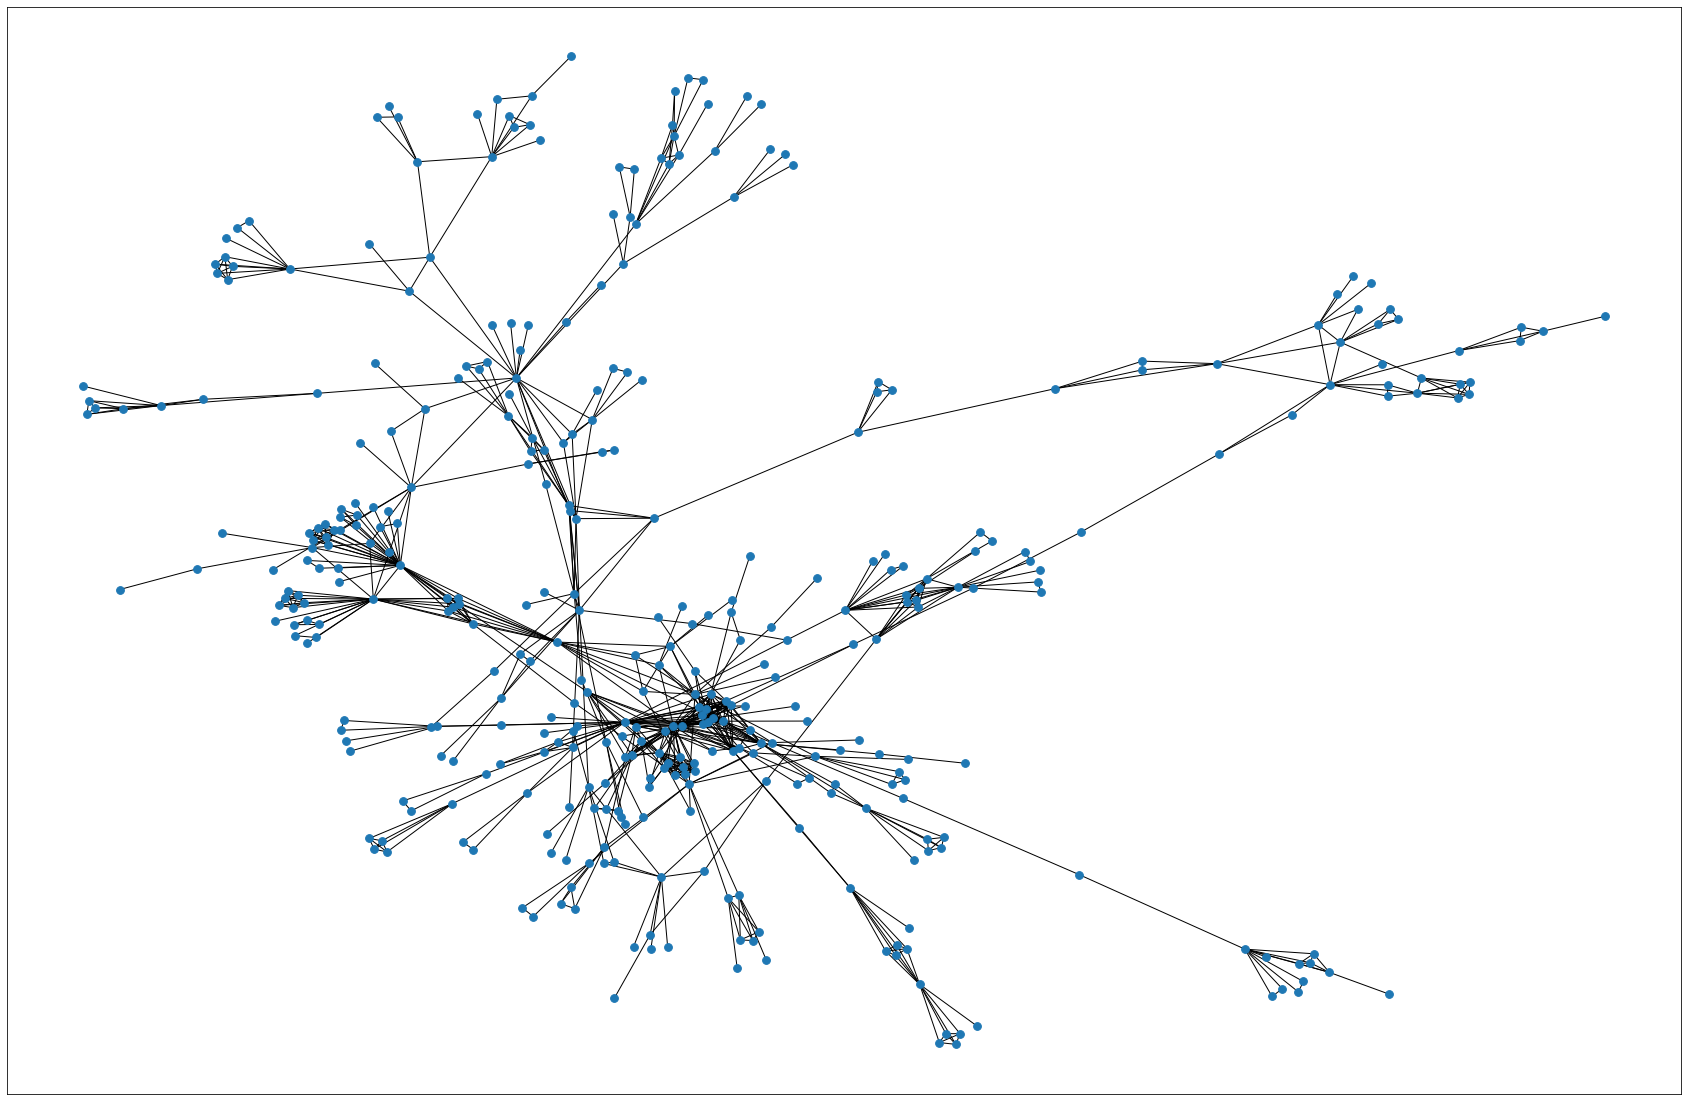

In [25]:
# project onto crimes and visualise
Sp = bipartite.weighted_projected_graph(S0, p_nodes_scc)

print('Sp',len(Sp.nodes()), len(Sp.edges()))

#Suspects only largest connected component
plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, with_labels=False)

In [26]:
communities_sp = sorted(comms.greedy_modularity_communities(Sp), key=len, reverse=True) #17 coms modularity 0.770
#communities_sp = sorted(comms.label_propagation_communities(Sp), key=len, reverse=True) #54 coms modularity 0.745

# Count the communities
print(f"There are {len(communities_sp)} communities.")

comms.modularity(Sp, communities_sp)

There are 17 communities.


0.7693752912474987

0 79
1 56
2 48
3 37
4 25
5 24
6 21
7 15
8 13
9 13


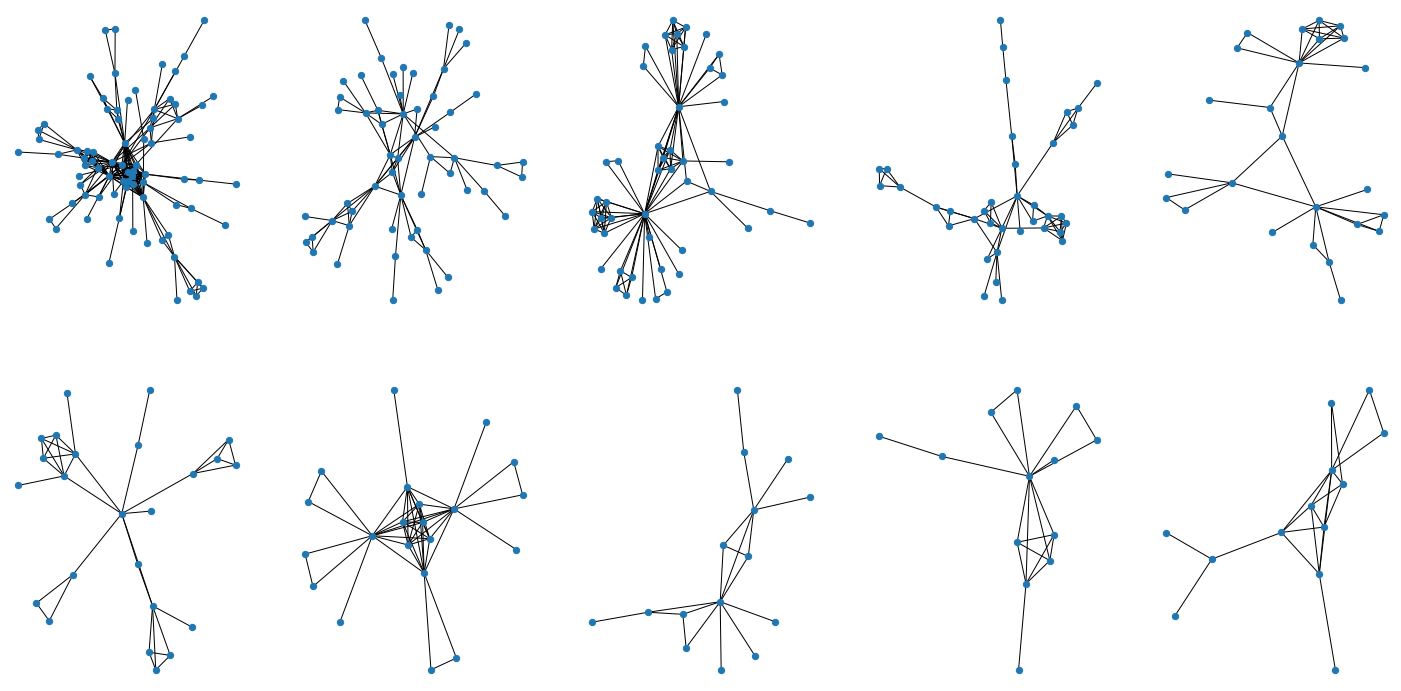

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    com = Sp.subgraph(communities_sp[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/1-10_Sp_community.jpg')

10 10
11 9
12 9
13 8
14 6
15 5
16 3


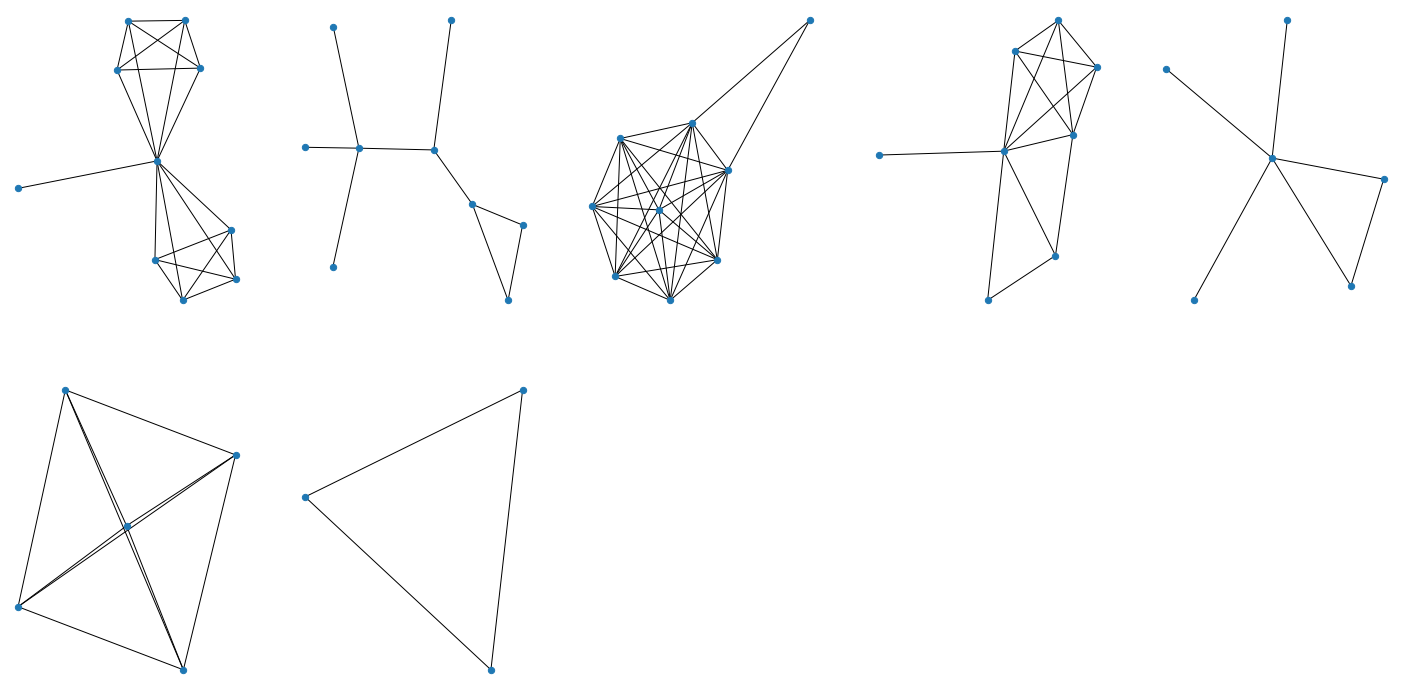

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(10,17): 
    com = Sp.subgraph(communities_sp[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-9)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/11-14_C_community.jpg')

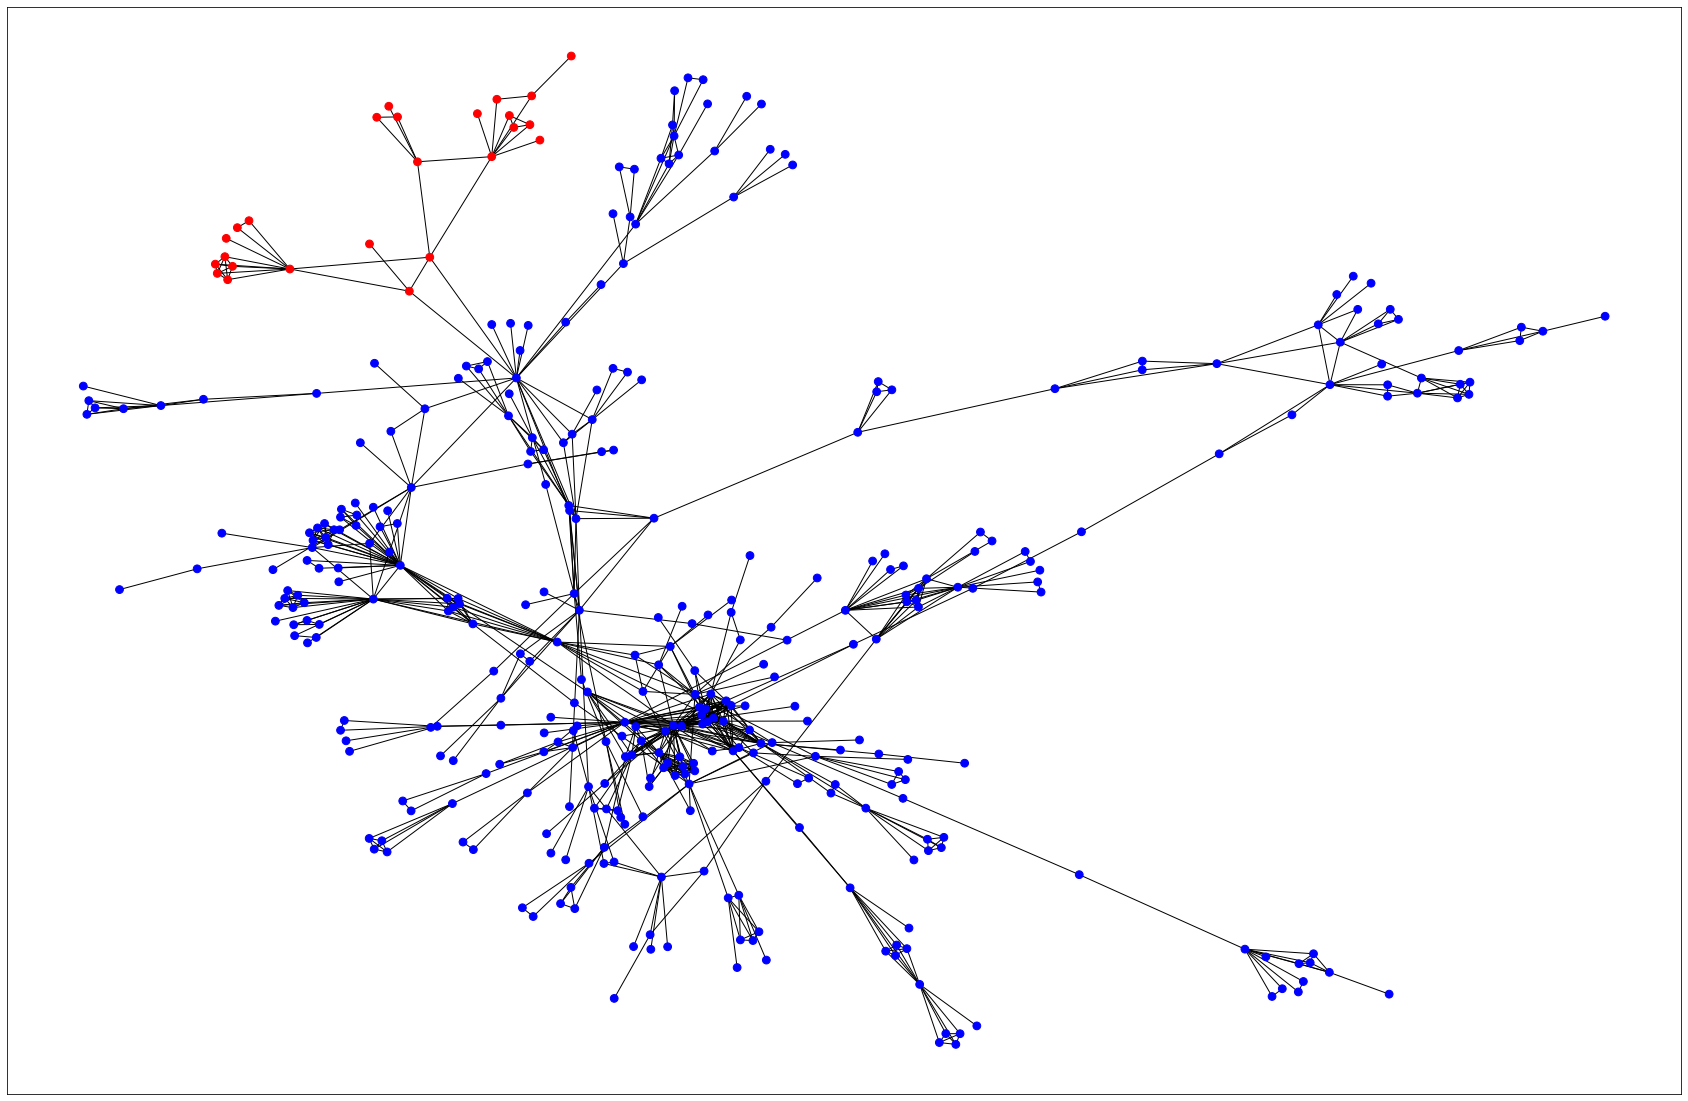

In [29]:
highlight = 4 #choose a community to highlight via it's index in the communities list

node_col = []

for node in Sp.nodes():
    if node in communities_sp[highlight]:
        node_col.append('red')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/community_{highlight}_people_projection.jpg')

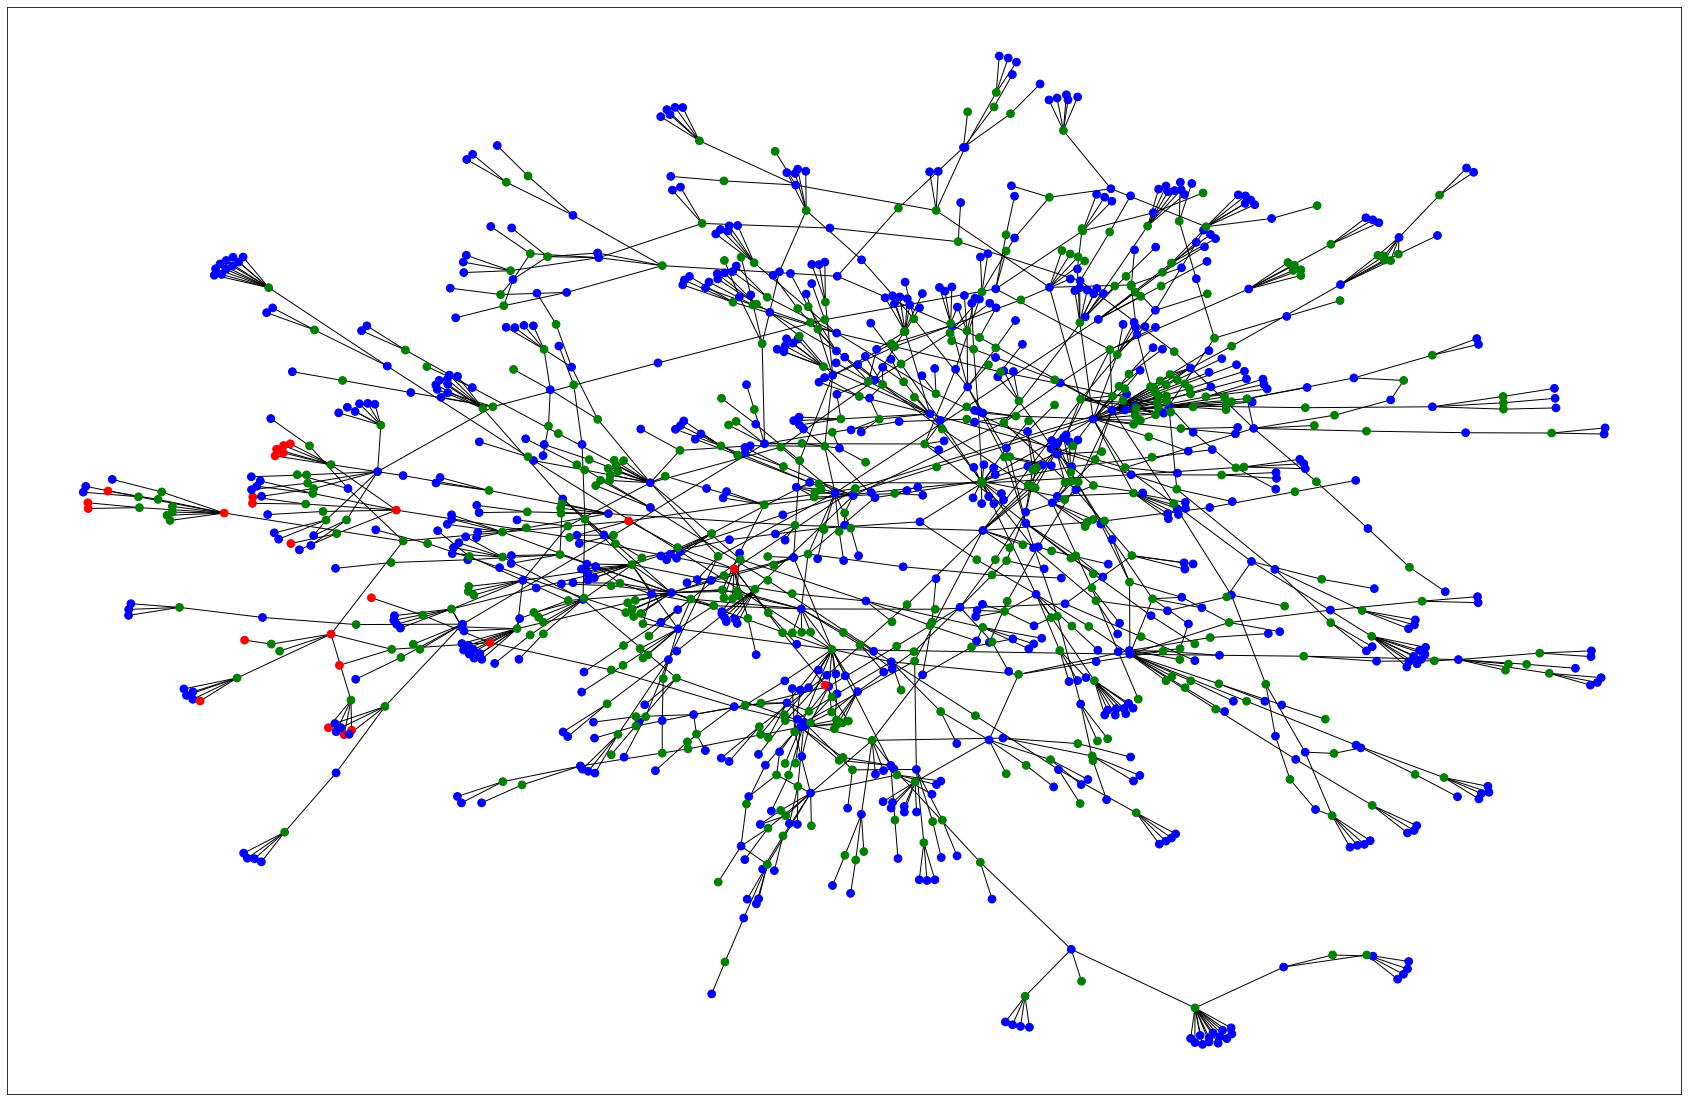

In [30]:
node_col = []

for node in G0.nodes():
    if node in communities_sp[highlight]:
        node_col.append('red')
    elif node in c_nodes_gcc:
        node_col.append('green')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/community_{highlight}_lcc_no projection.jpg')

In [31]:
ed = []
lab = {}

for per in communities_sp[highlight]:
    print('\n------\n\n',nx.get_node_attributes(G, 'last')[per], nx.get_node_attributes(G, 'sex')[per])
    lab[per] = (nx.get_node_attributes(G, 'last')[per], per)
    for c in G.edges([per]):
        print(c, nx.get_edge_attributes(G0, 'role')[c])
        ed.append(c[1])
        lab[c[1]] = f'{c[1]}'
        
for i in communities_sp[highlight]:
    ed.append(i)


------

 Vila 1
('p802', '114') Suspect

------

 Robbins 1
('p678', '262') Suspect

------

 Bishop 1
('p166', '116') Suspect

------

 Kenney 1
('p488', '447') Suspect

------

 Toomey 1
('p780', '262') Suspect

------

 Casson 1
('p233', '116') Suspect

------

 Carlson 0
('p217', '269') Suspect

------

 Ford 1
('p34', '64') Suspect

------

 Gillis 1
('p362', '115') Suspect
('p362', '220') Victim
('p362', '319') Victim

------

 Paulson 0
('p618', '262') Suspect

------

 Bender 1
('p148', '219') Suspect

------

 Lakin 1
('p505', '116') Suspect

------

 Johnson 1
('p469', '262') Suspect

------

 Samuel 1
('p692', '495') Witness
('p692', '520') Suspect

------

 Martin 1
('p553', '219') Suspect

------

 Ladd 1
('p504', '115') Suspect

------

 Faust 0
('p327', '269') Suspect

------

 Cotton 0
('p263', '319') Suspect

------

 Edgar 0
('p314', '343') Suspect

------

 Mullins 1
('p592', '252') Victim
('p592', '253') Victim Suspect
('p592', '351') Suspect
('p592', '352') Suspec

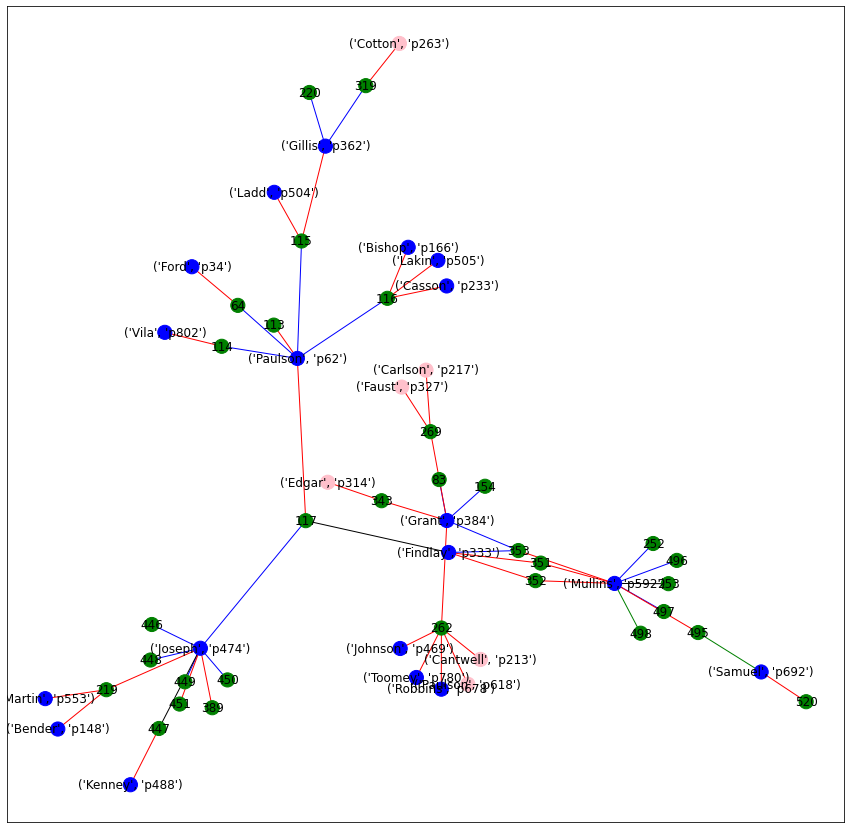

In [32]:
nc = []
ec = []

hi = G0.subgraph(ed)

for node in hi:
    if node in communities_sp[highlight]:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('blue')
        else:
            nc.append('pink')
    elif node in c_nodes_gcc:
        nc.append('green')
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
for edge in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[edge]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')
        
        

plt.rcParams.update({'figure.figsize': (15, 15)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

#plt.savefig(f'../Figures/community_{highlight}_focus_labelled.jpg')

In [38]:
for c in communities_sp:
    peeps = []
    for p in c:
        peeps.append(nx.get_node_attributes(G, 'last')[p])
    print(len(c), len(peeps), len(set(peeps)))


79 79 73
56 56 53
48 48 45
37 37 35
25 25 24
24 24 21
21 21 20
15 15 14
13 13 13
13 13 11
10 10 9
9 9 9
9 9 9
8 8 8
6 6 6
5 5 5
3 3 3
